Part II: Adjusting for bias.

# 4 Linear Regression

**Definition:** A linear regression is <u>bivariate</u> if there is one independent variable and one dependent variable; $Y=\tau T +\beta_0$.

Seems like monovariate is another name for this. Trivariate seems to refer to three independent and one dependent. So, just be aware of different authors' conventions. 

## Regression in A/B Tests 

The promise; standard error, confidence intervals and any other inference stats for come for free when you use linear regression to calculate ATE. 

e.g. A streaming service is trying to maximize `watch_time`. It has A/B tested a new recommender system $\text{challenger}$ on 1/3 of customers $\{i|\text{challenger}_i = 1\}$.  To measure the ATE you perform a fit of
$$
\text{watch_time} = \beta_0 +\beta_1 \text{challenger} + e
$$

Interpretation;
- $\hat{\beta}_0$ is average time spent watching with old recommender system
- $\hat{\beta_0}+\hat{\beta}_1$ is time spent watching with new 
- $\hat{\beta}_1$ is estimated ATE.

We well therefore call $\tau:=\beta_1$

---
## t Test For Regression Coefficients

Aside on $t$ statistic for regression coefficient $\beta_1$ in $y=\beta_1 + \beta_0 +e$:

Q: What does it mean for a regression coefficient  $\beta_i$ to have a mean or SE?

A:

First, center $X$ so we don't have to work with $\beta_0$. 

If the data matrix for $x$ is $X$ then the OLS fit to $y= \beta_1 x +  e$ is
$$\hat{\beta_1} = (X^T X)^{-1} X^T Y:= AY.$$
Therefore
$$
\begin{array}{ll}
\mathbb{V}(\hat{\beta}_1) &= A \mathbb{V}(Y)A^T \\
&=(X^T X)^{-1} X^T \mathbb{V}(Y) X (X^T X)^{-T}  \\
&= \mathbb{V}(Y)  (X^T X)^{-1} (X^T X) (X^T X)^{-T}  \\
&= \mathbb{V}(Y)  (X^T X)^{-T}  \\
&= \frac{ \mathbb{V}(Y)}{(X^T X)}  \\
&\stackrel{\text{centered}}{=} \frac{ \mathbb{V}(Y)}{(n-1)\mathbb{V}(X)}  \\
&= \frac{ \text{SE}_Y^2}{\sigma^2_X}  
\end{array}
$$

Note that the $1$ in there comes from the fact that we have a single independent variable in the model. 

Q: What is a $t$ test for the slope?  

A: The most common null hypothesis is that the actual slope is zero. In causal inference this is the null hypothsis that $\text{ATE}=0$. Then 
$$
\hat t=\frac{\hat{\beta}_1}{SE_{\beta} }
= \frac{\hat{\beta}_1}{\frac{\sigma_{\beta_1}}{\sqrt{n} }}
$$
Since $\hat{\beta}_1$ is the estimated ATE, both a large $\hat{\beta}_1$ and a small $\text{SE}$ signal a large value of $t$ and thus statistical significance. If the 95% CI $(\hat{\beta}_1 - 1.96 \text{SE}, \hat{\beta}_1+1.96 \text{SE})$ does not contain the null hypothesis value $0$ then the null hypothesis is rejected with 
- significance level $\alpha=5\%$
- confidence level $1- \alpha = 95\%$. 

--- 

```python
In[]: statsmodels.formula.api.smf.ols(formula = 'Y ~ T', data= df) 
```
indeed gives
- estimated coefficients $\beta_0,\beta_1$. 
- SE for them
- $\hat{t}$ 
- $P>|\hat{t}|$, which I take to be $\mathbb{P}(t>\hat{t} ) = 1-\text{CDF}_t(\hat{t})$ (Under the null hypothesis) 
- a two sided 95% CI ... for $\beta_i$ 



## Adjusting for Counfounding with Regression

In modeling the rate $\beta_1$ of default on credit line $D$ with respect to credit limit $L$ via
$$
D = \beta_0 + \beta_1 L + e
$$
there is confounding bias; credit is extended to those who are deemed not a risk based on other factors. Those factors are thus confounding variables $X$ (like wage, credit score, etc). Thus $\hat{\beta}_1$ is a biased estimator of $\text{ATE}$.

Finding $\tau$ in 
$$
D = \beta_0 + \tau L +\theta X+ e
$$
gives the  rate of default holding confounders constant, removing confounding bias in $\beta_1$.

**Definition:** When you want to find a regression coefficient, and need to add other coefficients to remove confounding bias, the other coefficients are <u>nuisance parameters</u>. 

## Coefficients as Covariance
The OLS estimate of $\tau$ in 
$$
Y= \tau T +e
$$ is
$$
\hat{\tau} = \frac{\text{Cov}(Y,T)}{\text{Var}(T)}
=\frac
{\mathbb{E}[(T-\bar{T})(Y-\bar{Y})]}
{\mathbb{E} [ (T-\bar{T})^2]}.
$$

Regression is a quantification of how $T$ and $Y$ move together, and rescales by units of treatment. 

Me: Note the similarity to sying that $X$ is centered and then saying
$$
\hat{\beta}=(X^TX)^{-1} X^TY. 
$$

## Frisch-Waugh-Lovell 
(FWL)

### Building intuition:

There is an enlightening way to estimate $\tau$ in 
$$y=\beta_0 +\tau T + \beta X +u.$$
Fit $T = \delta_1 X +\delta_0$ and obtain the residuals $\tilde{T_i}$. Then
$$
\hat{\tau} = \frac{\text{Cov}(Y,\tilde{T})}{\text{Var}(\tilde{T})}
$$


Thus, you can account for the effect on $Y$ of other variables $X$ in the model besides $T$ by 
1. fitting $T$ as a function of those other variables, and then 
2. fitting $Y=\tau \tilde{T} + \delta_0$ to obtain $\hat{\tau}$


That is, $\tau$ is the the bivariate coefficient of $T$ after accounting for all other variables to predict $T$.


Intuition:  
- If you can predict $T$ using $X$ then $T$ is not random WRT $X$. 
- Residuals $\tilde{T}$ are random WRT $X$. 

Here is my visualization. I attempt to show how confounding bias, and how not correcting for it, can give the opposite sign ATE of the true ATE when $X$ and $T$ are not independent.

<img src="images/IMG_6899.jpg" width="400">

(that picture shows the debiasing step but not the denoising step from FWL below) 

The above sets up intuition for the following 
### FWL Theorem

**Theorem** (Frisch–Waugh–Lovell): 
Fitting $Y= \tau T + \beta_1 X +\beta_0 +e$ yields the same $\hat{\tau}$ as performing three steps:
1. A debiasing step: regress T on X and obtain residuals $\tilde{T} := T − \hat{T}$
2. A denoising step: regress Y on X and obtain residuals $\tilde{Y} = Y − \hat{Y}$
3. Outcome model: regress the $\tilde{Y}$ on residual $\tilde{T}$ to obtain an estimate $\hat{\tau}$ for the causal effect $\tau$ of $T$ on $Y$.

The standard error of the estimator of the regression parameter is obtainable from the residuals in the first two steps; (seems like this should be called a theorem)
$$
\begin{array}{ll}
\mathbb{V}(\hat{\tau}) 
&= \frac{ \text{SE}_Y^2}{\sigma^2_X}  \\
&= \left(\frac{\sigma(\tilde{Y})} { \sigma(\tilde{T}) \sqrt{n-\text{DF}}} \right)^2
\end{array}
$$
where $n$ is the number of points and DF is the number of parameters estimated by the model including the intercept $\beta_0$. (so $shape(\tau)+shape(\beta_1)+shape(\beta_0)$, but the noise is not a parameter.)






Lets unfold this
- numerator: The more consistant the estimate of $Y$ from $X$ the smaller the uncertainty in $\hat\tau$. 
- denominator: 
    - the less consistant the estimate of $T$ from $X$ the smaller $SE(\tau)$ (because $X$ is worse at predicting $T$). Their wording: When treatment varies a lot it is easier to measure the impact of treatment. But... variation of treatment is not what appears here. 
    - 4 times more points gives about half the variance of $\hat{\tau}$.

### Visualization

Their diagram is pretty sexy; 

#### Debiasing 
is constructing the fit
$T = a X +b$
and then applying the transformation 
$$
\left[\begin{array}{c} X \\ \tilde{T} \end{array} \right]
= \left[\begin{array}{cc} 1 & 0 \\ -a &1 \end{array} \right]
\left[ \begin{array}{c} X \\ T\end{array}  \right]
+\left[  \begin{array}{c} 0 \\ -b \end{array}\right]
$$

For just the data set pictured below, This is exactly finding the average $T$ value at each $X$ value, and then 
- translating along the T axis by $b$
- shearing in the $\tilde{T},X$ plane along the $T$ axis to bring the averages to zero. 

For more general data sets you can't say "average T value at each y" but you certainly can say "average T value" and after the translation and shearing the data will have the $\tilde{T}=0$ axis as the line of best fit. 

That shearing in the $X,T$ plane can not be seen in the $T,Y$ plane other than translation that varies by color. In their image, the average T value at each X value is brought to zero because the centroids laid on a line to begin with. Note that one can find $\hat{\tau}$ after debiasing, but one deals with a lot of noise, as seen in the vertical variation. 

In the loftmost image the black line is line of best fit. In the other two images the black lines are average T values for each $X$ value. 

<img src="images/debias.png" width="300">

#### Denoising  
is constructing the fit $Y=cX+d$ and then applying the transformation 
$$
\left[\begin{array}{c} X \\ \tilde{Y} \end{array} \right]
= \left[\begin{array}{cc} 1 & 0 \\ -c &1 \end{array} \right]
\left[ \begin{array}{c} X \\ Y\end{array}  \right]
+\left[  \begin{array}{c} 0 \\ -d \end{array}\right]
$$
This is exactly finding the average Y value at each X value, and then translating along the $Y$ axis plus shearing along the $Y$ axis in the $T,X$ plane. In the $Y,T$ plane, this just looks like color dependent translation. This denoising translation decreases the variance in heights. The value of  $\hat{\tau}$  found after this translation is the same as that before, but the variance of $\tau$ is smaller and thus the  likelihood of rejecting the null hypothesis is greater. 


<img src="images/denoise.png" width="300">

After debiasing, $\tilde{T}\perp X$.

After denoising $\tilde{Y} \perp X$. 

**Definition:** The result of these two transformations, debiasing and denoising is <u>orthogonalization</u>

ME: If you want to use angles, consider the inner product to be correlation $\langle A,B\rangle =\rho(a,b)$. 


Thus, fitting $\tilde{Y} = \tau \tilde{T}$ is not effected by $X$ because "$X$ is random" as far as $\tilde Y$ and $\tilde T$ are concerned. 

## Regression of Potential Outcomes

Regression of $Y$ on $X$  over the control population (${Y}_0 = a X + b$) yields $\hat{Y}_0(x) = \hat a x + \hat b$. This function provides a way to impute $Y_0$ on the $T=1$ population; it therefore provides a way to estimate ATT as
$$
\begin{array}{ll}
\text{ATT} & := E[Y_1|T=1] - E[Y_0|T=1] \\
& \stackrel{\text{impute}}{\approx}  E[Y_1|T=1] -\frac1{N_1} \sum\limits_{i\in\{i|T_i=1\}} (aX_i+b) \\
&\stackrel{\text{emperical}}{=} \frac1{|\{i|T_i=1\}|}\sum\limits_{i\in\{i|T_i=1\} }
[Y_{i1}- (aX_i+b)]
\end{array}
$$

Regression of $Y$ on $X$ over the treated poulation ${Y}_1 = cX+d$ yields $\hat{Y}_1 (x)= \hat c x+ \hat d$, so how about you average over the whole population to get ATE? 
$$
ATE \approx \frac1N \sum_{i=1}^N [ (cx_i+d) -(ax_i+b)]
$$



## Conditionally Random Experiments

Work backwards from the fact that we have these regression tools that work when the CIA $(Y_0,Y_1 \perp T |X)$ holds.

We can create experiments where  $(Y_0,Y_1 \perp T |X)$ by design; let treatment assignment be random for each group with constant $X=x$ using Bernoulli probability of success $p$ to assign treatment with $p: \{x\} \to (0,1)$ dependant only on $x$. ($p(x)$ in the language I have come to detest.) 

e.g.  Say it is deemed to expensive to run a randomized experiment of giving people credit lines, meaing assigning new credit lines to all people according to the same $p=0.1$ Bernoulli distribution. Then, to perform a conditionally random experiment, you CAN give higher risk people a lower $p=0.01$ value for a Bernoulli distribution, lower risk people a higher $p=0.21$ value for a Bernoulli distribution. Run the experiment, and use CIA tools to reconstruct the ATE, ATT etc. You can bin credit scores in any way you want, and then you have the luxury of knowing exactly how they were binned, as opposed to the forwards version! e.g. You can make $p$ a function of only credit score rounded to the nearest hundred.  

Be careful! Overlap in treatment groups is needed! Dont assign 100% of the people in some group the same treatment! That violates the common support assumption (aka positivity).

### Dummy Variables for Variable Intecept

Say that you run a contitionally random experiment, or that you otherwise have a categorical confounding variable $G$. (Thus there will be no $X$.) One hot encode to get features $G_j$. You are going to fit
$$
Y=\tau T +\beta_0+\theta_j G^j
$$
While I am comfortable thinking about $\theta_j$ as a slope in going from the ommitted group to the group $j$, another way of thinking is that you get a differnt intercept $\beta_0 + \theta_i$ in $T$ vs $Y$ for each of the $G_i$. 

<img src="images/fit_by_group.png" width="300">


### Saturated Regression Model: Dummies for Variable Slope

By contrast, in the model
$$
Y=\beta_0+ \theta_j T G^j
$$
the parameter $\theta_i$ is the rate of change of $Y$ WRT $T$ for bucket $j$. 

In patsy formula syntax, the $:$ operator will give you that. By contrast, the $*$ operator will give 
$$
Y=\beta_0 + \beta_j  G^j+ \theta_j T G^j
$$
so that there is a different intercept $\beta_0 + \beta_j$ for each category, as seen in in the output below. 

```python
model = smf.ols("default ~ credit_limit * C(credit_score1_buckets)",
                             data=risk_data_rnd).fit()
```

<img src="images/bucket_affines.png" width="300">

<img src="images/saturated_regression.png" width="300">

The slope called `credit_limit` here is the slope for the group omitted in one hot encoding. In the image, the expreme slope is likely from a small sample size allowing large variance. 

Now, each fitted line has differnt intercept and different slope. 

The ATE of credit limit on default rate is the weighted average of these slopes weighted by number of samples (Facure says, but I am worried about weighting by variance being the correct way to get an unbiased ATE  estimate). 

Presumably this is called saturated regression. 

ChatGPT says "saturated regression refers to a modeling approach that includes all possible covariates or predictors in a regression model." I objected that since the product of two features is a feature, there are infinitely many features.... so the defnition it gives is nonsesense. It said, that is correct, but reserachers must decide which are important. 

### Weighted Averages

This is my best guess of what they are trying to say: 

$\hat{\tau}$ from 
$$
Y=\beta_0 +\tau T \\
$$
is equal to the variance weighted average over $\{\hat{\tau} + \hat{\theta}_j | j =1,...\}$ from
$$
Y=\tau T +\beta_0+\theta_i G^j
$$
and equal to sample size weighted average over $\{ \hat{\theta}_j| j=1,... \}$ in 
$$
Y=\beta_0+ \theta_i T G_j .
$$

Remember that 
$$
\hat{\tau} = \frac{\text{Cov}(Y,T)}{\text{Var}(T)}
=\frac
{\mathbb{E}[(T-\bar{T})(Y-\bar{Y})]}
{\mathbb{E} [ (T-\bar{T})^2]}
$$ 

This difference is at the heart of the following:

"In 2020, the econometric field went through a renaissance regarding the diff-in- diff method"

In [51]:
risk_data = pd.read_csv("./causal-inference-in-python/data/risk_data.csv")
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

print(X.shape), print(y.shape)

(50000, 5)
(50000,)


(None, None)

In [52]:
def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

---- 

Example:
- continuous T
- 2 groups, labeled by $g\in \{1,2\}$. 
    - Group 1 has 
        - 1_000 units with 
        - $\text{ATE}_1 =1$ expressed as slope WRT T 
        - variance of $\mathbb{T}^2 = 1$
    - Group 2 has 
        - 500 units with 
        - $\text{ATE}_2 =2$ expressed as slope WRT T 
        - variance of $\mathbb{T}^2 = 2$


In [203]:
import numpy as np
import pandas as pd 

np.random.seed(123)
t1 = np.random.normal(loc=0, scale=1, size=1_000) 
t2 = np.random.normal(loc=0, scale=2, size=500)
df1 = pd.DataFrame(dict(t=t1, y=1.0*t1, g=1))
df2 = pd.DataFrame(dict(t=t2, y=2.0*t2, g=2))
df = pd.concat([df1,df2])

Regression $Y=\tau T + \theta^i G_i +\beta$ yields $\hat{\tau} =1.67$.

In [234]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params['t']

1.6681955761233118

Regression $ Y_j = \tau_j T + \beta_j$ on each group gives $\hat{\tau}_1$ and $\hat{\tau}_2$ that you'd think average to $1.67$ via a weighted average by samples size. It does not

In [235]:
import statsmodels.formula.api as smf

# Regression Y= tau T +beta, slope coefficient by statsmodels
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]


# Slope for each group 
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")

# average by sample size 

sizes = df.groupby("g").size()
size_weighted_terms = effect_by_group*sizes

weighted_average_ate = (size_weighted_terms).sum()/sizes.sum()
weighted_average_ate

1.3333333333333333

The question is why $\hat{\tau}_1$ and $\hat{\tau}_2$ do not average to $1.67$.

The answer is that standard deviation of $T$ is the correct weight to use.

In [230]:
def std(y):
    return y.std()

# pg 130 
# "weights that are proportional to the variance of the treatment in each group."
weights_of_groups = (df.groupby("g").apply(std)['t'])

# average by variance of t for group

var_weighted_terms = effect_by_group*(weights_of_groups)
var_weighted_average_ate = (var_weighted_terms).sum()/weights_of_groups.sum()
var_weighted_average_ate

1.6674426621121978

That is, the categorical dummy $Y = \tau T + \theta^j G_j + \beta $ fit was weighting by standard deviation the $\tau_j$ for the groups by standard deviation. 


### De-Meaning and Fixed Effects

There was talk earlier of FWL removing the mean from each bucket. 

**Definition:** Subtracting the mean of the bucket from each bucket is <u>de-meaning</u>. 

The python syntax for fitting on de-meaned data follows.
```python
risk_data_fe = risk_data_rnd.assign( 
    credit_limit_avg = lambda d: (d.groupby("credit_score1_buckets")
                                               ["credit_limit"].transform("mean"))
)
model = smf.ols("default ~ I(credit_limit-credit_limit_avg)",
                             data=risk_data_fe).fit()
```

This gives the same $\hat{\tau}$ as when we used dummies. 

The term "fixed effects" means controlling for something (like the group outcome mean) that is fixed within a group. 

## Omitted Variable Bias: Confounding Through the Lens of Regression

Regression allows you to be precise about the confounding bias by talking about the long model, the omitted model, and the debiasing model

$$
\begin{array}{ll}
\text{Short model}     &Y = \tau' T + \beta^{'}_0\\
\text{Long Model}      &Y = \tau T + \beta_1 X + \beta_0\\ 
\text{Debiasing Model} &X = \delta_1 T + \delta_0\\            
\end{array}
$$
    
$$\hat{\tau}' = \hat{\tau} + \hat{\beta_1} \hat{\delta}_1 $$

Or in garble... The biased estimate of ATE due to an omitted variable is equal to 
the effect in the model where it is included 
plus 
the effect of the omitted variable on the outcome 
times the regression of omitted on included. (On included? On treatment?)


## Neutral Controls

What kind of variables should you include in X? 

Potential problems: common effects (colliders) and mediators  induce selection bias.

Priming: there is a bias–variance trade-off when it comes to including certain variables in your regression 

**Definition:** In causal inference via regression <u>controls</u> are the confounding variables that are included in a regression model.

Use of a particular confounding variable might induce more bias in the estimator. In fact, there is a bias-variance tradeoff we need to explore.

**Definition:** In causal inference <u>neutral controls</u> are confounding variables that are included in a regression model to reduce bias of the estimated causal relationship.

Demonstrating the need for a differnce calls for an example in code below. 

#### Bias down, Variance up
Note that in the code below $x_3$ is a stronger predictor of $T$ than of $y$ by two orders of magnitude. 

The estimator $\hat \tau$ of the coefficient of $t$ in $Y= \tau T + \beta^i x_i + \beta_0$ and its variance $\mathbb{V}(\hat \tau)$ can be estimated  from the Frisch-Waugh-Lovell debiasing $\tilde T$ and denoising  $\tilde Y$, as
$$
\hat \tau = \frac{\text{Cov}(\tilde T,\tilde Y)}{\text{var}( \tilde T)}
$$
$$
\mathbb{V}(\hat{\tau}) = \frac{ \text{Var}(\tilde Y)}{\text{Var}( \tilde T) (N-DF)}.
$$
Since $x_3$ is a stronger predictor of $T$ than of $y$, w anticipate the use of $x_3$ to
1. increase  $\text{Var}(\hat \tau)$ by decreasing $\text{Var}(\tilde T)$ 
2. decrease bias to the coefficient of $t$, which is supposed to be 5, by controlling for fewer confounding variables.  


In [242]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as sms

def var_bias():
    (x1,x2,x3) = (np.random.normal(loc = 0 , scale=1, size = 100) for _ in range(3))
    t = np.random.normal(loc =     0.1*x1 + 1*x2 + 10.*x3, scale =1)
    y = np.random.normal(loc= 5*t+ 10.*x1 + 1*x2 + 0.1*x3, scale =1)
    df = pd.DataFrame( data = dict(t=t,y=y, x1=x1,x2=x2,x3=x3))
    nox3 = sms.ols("y ~ t + x1 + x2 ", data = df).fit()
    withx3 = sms.ols("y ~ t + x1 + x2 + x3", data = df).fit()
    se_boost = withx3.bse['t']/nox3.bse['t'] 
    # bias_boost = (5-withx3.params['t'])/(5- nox3.params['t'])
    bias_diff = (withx3.params['t']-5)-(nox3.params['t']-5)

    return  se_boost, bias_diff

bv_df = pd.DataFrame(columns=['se_boost','bias_diff'])
for i in range(100):
    bv_df.loc[i] = var_bias()

bv_df.mean()

se_boost     10.033422
bias_diff    -0.012452
dtype: float64

Indeed
1. $\text{Var}(\hat \tau)$ goes up by an order of magnitude with use of $x_3$
2. bias goes down by a little (a quarter of a percent of the parameter being estimated, 5)

In [243]:
(0.012452/5)*100

0.24903999999999998

Side note: The desoising technique CUPED, developed by Microsoft researchers, is very similar to just doing the denoising part of the FWL theorem.


#### Bias up, Variance down

Message: Sometimes it is worth accepting a bit of bias in order to reduce variance. 

It’s really hard to have a situation where a covariate causes the treatment but not the outcome. Usually you have multiple covariates, and for a single $X_i$ there are different level of intensity of cause on T and Y, as visualized below.

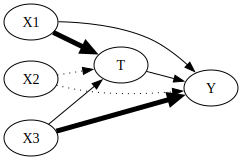

In [9]:
import graphviz as gr
# Order here seems to determine vertical order in the visualization.
g = gr.Digraph(graph_attr={"rankdir": "LR"})
g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", #penwidth="3", 
       style="dotted"),
g.edge("X3", "T", penwidth="1"),
g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", #penwidth="3", 
       style = "dotted"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

$X_1$ explains away variance in $T$ (and thus increases variance in $\hat{\tau}$) more than it removes bias. 

$X_3$ reduces confounder bias more than explaining variance in $T$. 

Seems to me like $X_1$ is a bad choice for variable to control for, $X_2$ is good. 

In [246]:
np.random.seed(123)
n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3)) 
t = np.random.normal(10*x1 + 5*x2 + x3)
# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))
smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


The 95% CI contains 0 so we can not reject $H_0: \tau =0$. This is because the variance in $T$ is too big because $X_1$ is explaining away variance in $T$ and thus increasing variance in $\hat{\tau}$.

Removing $X_1$ from the fit, the 95% CI fot $\hat{\tau}$ no longer contains 0 and thus the null hypothesis can be rejected.  



In [3]:
smf.ols("Y~T+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
T,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


So, if a confounding factor explains the treatment too much and almost nothing about the outcome, you should really consider dropping it; it is not worth the increase in variance to have a small decrease in bias.

Exactly how weak the confounder should be in terms of explaining the treatment to justify removing it is still an open question in causal inference research.

# 5 Propensity Score

In orthogonalization we build models of $T$ and $Y$ to obtain residuals to debias and denoise. 

In propensity weighting, we build models of treatment assignment and uses the model’s prediction to reweight the data. 

**Definition:** A <u>propensity score</u>  $e(x)$ is an estimator of $P( T |X=x)$.

In the binary treatment case, propensity score estimates $E(T|X=x)$ 

You can simply condition on the propensity score in order to block the backdoor paths that flow through X.

<img src="images/propensity_graph.svg" width="300">

Think about it: if $i$ and $j$ have the exact same probability of receiving the treatment, the only reason one of them did and the other didn’t is pure chance. 

In a (perfectly executed) conditional experiment you would havbe the true $P(T|X)$. In an observational study you need to estimate it with some $e(x)$. 

For binary treatment, logistic regression is used. 


Recall that OLS estimates $T$ as a function of $X$ in the debiasing phase. That is, it estimates $E[T|X=x]$. But a linear estimate of binary outcome  vs continuous $x$ is pretty bad. 

Fitting the logistic regression for a propensity score
$$
e = \sigma(\beta_1 X + \beta_0)
$$
and then 
$$
Y = \tau T + \delta e
$$
has an effect on $\hat{\tau}$ very similar to debiasing. The difference; OLS modeled $T(X)$ linearly, propensity score modeled it logistically.


Propensity score is a dimensionality reduction to one dimension; it thus provides a notion of distance. 

In propensity score matching you look for nearest neighbors of each unit in the other treatment group, and average over treatment effect differences. The use of KNN here is fround upon by the author; 
- it is difficult to derive the variance of the resulting $\hat{\tau}$.
- inefficiency of kNN in high dimension when conditioning on $e$ is not a good replacement for the problem of dimsnsionality when using $X$. 




See the paper  “Why Propensity Scores Should Not Be Used for Matching,” by King and Nielsen

### Inverse Propensity Weighting
Here is a novel way to account for confounding bias; $X$ causes $T$ and $Y$, and we need to close that back door of association. 

If $i$ was treated but $e(x_i) \approx 0 $ then $i$ looks a lot like the untreated.  

Thus, $Y_i$ provides an estimate of the counterfactual  $E[Y_1| T = 0, X=x_i]$. 

We'd like to use many of these interesting individuals. We'd also like to give more weight lower the $e$, since they look like they are in the other group. 

The weighting 
$$E{[Y_t]} := E\left[ \frac{\mathbb{1}(T=t)Y}{P[T=t|X=x]} \right]$$ 
makes treatment appear to have been randomly weighted.

In the case of binary treatment this reads
$$
E{[Y_1]} = E\left[ \frac{\mathbb{1}(T=1)Y}{P[T=1|X=x]} \right] 
\stackrel{\text{model } e}{\approx} E\left[ \frac{\mathbb{1}(T=1)Y}{ e(x)}\right] 
\stackrel{\text{emperical}}{\approx} \frac1{\vert\{i|T_i=1\}\vert} \sum\limits_{i\in \{i|T_i=1\}} \frac{Y_i}{e(x_i)}
\\ 
E{[Y_0]} = E\left[ \frac{\mathbb{1}(T=0)Y}{P[T=0|X=x]} \right] 
\stackrel{\text{model } e}{\approx} E\left[ \frac{\mathbb{1}(T=1)Y}{1- e(x)}\right] 
\stackrel{\text{emperical}}{\approx} \frac1{\vert \{i|T_i=0\} \vert} \sum\limits_{i\in \{i|T_i=0\}} \frac{Y_i}{1-e(x_i)}
\\ 
$$

This provides the estimate
$$
\text{ATE} = E{[Y_1]} - E[Y_0].
$$

In the plot below, the size of the marker indicates weight. You see that heavy weight is given to 
- the treated with a low (predicted) probability of treatment (large triangles)
- the untreated with high probability of treatment (large circles)

<img src="images/IPW.png" width="300"> 

High weight to 
- the treated who look untreated, 
- the untreated who look treated. 

---
#### Confusions:

Discussion on modeling: There is no training of a model to predict $Y$ in IPW. The only model is $e$. That seems magical; we get ATE modeiling only $e$. 

Discussion on $X$ conditioning; I keep thinking that this is giving a $X$ conditioned ATE... but it is not; Those expectation values have estimators that are sums over all units $i$.


Discussion on "pseudo-population" 

I'm struggling with this phrase;

The quantity
$$E{[Y_t]} := E\left[ \frac{\mathbb{1}(T=t)Y}{P[T=t|X=x]} \right]$$ 
creates a pseudo-population that approximates what would have happened if everyone had received the treatment $t$.

Well... its emperical estimator is a average over units who did recieve treatmet $t$.... and the quantity averaged is an inflated effect $Y_i/e(x_i)$. That is hardly "everyone recieved the treatment $t$." Those who were unlikely to recieve the treatment $t$ were given high inflation. 

REally, I'm just wondering how the effect of this inflation vanishes; these quantities seem like they are just bigger than the terms in ATE. I guess, in the end, the way to see that they wash out is with the algebra revelations below.

---

#### Python e.g.
We will want to see if an intervention like manager training increases a manager's engagement with underlings as measured by $Y=$`engagement_score`.

In [1]:
import pandas as pd 
import numpy as np
df = pd.read_csv("./causal-inference-in-python/data/management_training.csv")
df.head()

,departament_id,intervention,engagement_score,tenure,n_of_reports,gender,role,last_engagement_score,department_score,department_size
0,76,1,0.277359,6,4,2,4,0.614261,0.224077,843
1,76,1,-0.449646,4,8,2,4,0.069636,0.224077,843
2,76,1,0.769703,6,4,2,4,0.866918,0.224077,843
3,76,1,-0.121763,6,4,2,4,0.029071,0.224077,843
4,76,1,1.526147,6,4,1,4,0.589857,0.224077,843


We start by building a model of the probability of intervention as a function of some of the other features. This is a propensity score.

In [5]:
import statsmodels.formula.api as smf
ps_model = smf.logit("""intervention ~
            tenure + last_engagement_score + department_score
            + C(n_of_reports) + C(gender) + C(role)""", data=df).fit(disp=0)

With this, we assign a propensity score to each manager.

In [6]:
data_ps = df.assign(propensity_score = ps_model.predict(df))
data_ps[["intervention", "engagement_score", "propensity_score"]].head()

,intervention,engagement_score,propensity_score
0,1,0.277359,0.596106
1,1,-0.449646,0.391138
2,1,0.769703,0.602578
3,1,-0.121763,0.580990
4,1,1.526147,0.619976


Calculate inverse propensity weight (IPW) to go with each engagement score ($Y$), and the inverse propensity score weighted $Y_i$s.

In [9]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
# WTF... these are effects, they are Ys. 
y1s = data_ps.query("intervention==1")["engagement_score"]
y0s = data_ps.query("intervention==0")["engagement_score"]
ipw_y1s = y1s*weight_t
ipw_y0s = y0s*weight_nt

We then calculate the mean over units in the treatment groups; This is 
- not a weighted average with inverse propensity scores as weights inverse propensity score, is it 
- the mean of weighted effects. 

In [10]:
Ey1 = sum(ipw_y1s)/len(data_ps)
Ey0 = sum(ipw_y0s)/len(data_ps)
print("E[Y1]:", Ey1)
print("E[Y0]:", Ey0)
print("ATE", Ey1 - Ey0)

E[Y1]: 0.11656317232946731
E[Y0]: -0.14941553647814407
ATE 0.2659787088076114


### Algebra Revelations

With binary $T$, the estimator of ATE for IPW is 
$$
\begin{array}{ll}
\hat{\tau}_{\text{IPW}} &= 
E\left[   
\frac{ \mathbb{1}(T=1)Y }
{P(T=1|X)}  
\right]
-
E\left[   
\frac{ \mathbb{1}(T=0 )Y }
{P(T=0|X)}  
\right]\\
& =E\left[ 
Y\frac{T-e(x)}{e(x)(1-e(x))}
\right]\\
& =E\left[ 
\frac{Y(T-E(T|X))}{\mathbb{V}(T|X))}
\right]\\
& = 
\frac{E[Y(T-E(T|X))]}{\mathbb{V}(T|X))}
\\
\end{array}
$$


where I have used that the variance of a Bernoulli distribution with $p=e(x)$ is $p(1-p)$. 

Note that is is very similar to what OLS gives as an estimate:
$$
\begin{array}{ll}
\hat{\tau}_{ols}& = 
\frac{E(Y(T-E(T|X)))}{ E (\mathbb{V}(T|X)))}\\
&=
\frac{E(Y(T-E(T|X)))}{ \mathbb{V}(T|X))} \frac{\mathbb{V}(T|X))}{E [\mathbb{V}(T|X))]}\\
&=\hat{\tau}_{\text{IPW}} \frac{\mathbb{V}(T|X))}{E [\mathbb{V}(T|X))]}
\end{array}
$$

IPW weights each sample by 1, while OLS weights the group effects by the conditional treatment variance.

Standard error for IPW is calculated with the bootstrap method; repeatedly
- resample data with replacement, 
- use the sample generate $\hat{\tau}_{\text{IPW}}$  

Then generate a histogram of $\hat{\tau}_{\text{IPW}}$  values, normalize it for a PDF, find the 2.5th and 97.5th percentile, there is your confidence interval. 

The section on Stabilized Propensity Weights simply advises weighting by $\frac{P(T=t)}{P(T+t|X)}$ and notes the analogy with a common data science technique called "importance sampling". I also glazed over pseudo population ideas. 

### Propensity score for Selection Bias

You saw how to use propensity score weighting as a way to account and control for confounding bias

For a second time... I do not have the oomph here. 

### Design
which one should you use and when? Regression or IPW?

**Definition:** <u>Model-based identification</u> involves making assumptions in the form of a model of the potential outcomes conditioned on the treatment and additional covariates.

**Definition:** <u>design-based identification</u> is all about making assumptions about the treatment assignment mechanism. 

Frisch-Waugh-Lovell is both; it is 
- designed based because you model $T$ as a function of $X$ (debiasing) 
- model based because you model $Y$ as a function of $\tilde{T}$. 


IPW is purely design based; it is about modeling $T$ as a logistic function of $X$. 

Later we will learn about Synthetic Control, which is purely model-based.

ask yourself which type of assumption you are more comfortable with, that 
- you can model the treatment assignment 
- you can model the potential outcomes

## Doubly Robust Estimation 

There is a slick way to simultaneously try a model based identification and a design based identification; 

## Continuous treatment

Continuous treatments are way more complicated to deal with. So much so that I would say that causal inference as a science doesn’t have a very good answer on how to deal with them.

